In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
train_df = pd.read_csv('train_1Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_1Dx.csv',nrows=50000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = tf.gather(params=p, indices=[1], axis=1)
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(tf.math.multiply_no_nan(likelihood,tf.cast(sigma>0,tf.float32)),minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [6]:
from qkeras import *

def CreateQModel(shape):
    x = x_in = Input(shape)
    #x = BatchNormalization()(x)
    x = QDense(64, 
               kernel_quantizer=quantized_bits(32), 
               bias_quantizer=quantized_bits(36),
               name="dense1")(x)
    #x = BatchNormalization()(x)
    x = QActivation("relu", name="relu1")(x)
    x = QDense(2, 
               kernel_quantizer=quantized_bits(32), 
               bias_quantizer=quantized_bits(36),
               name="dense2")(x)
    
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateQModel(X_train.shape[1:])

model.compile(optimizer=Adam(),
              loss=custom_loss)

model.summary()

2022-11-02 20:04:30.891234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 20:04:30.928773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 20:04:30.929124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 20:04:30.930043: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (QDense)             (None, 64)                1408      
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 dense2 (QDense)             (None, 2)                 130       
                                                                 
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________


In [7]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/80
   67/12500 [..............................] - ETA: 29s - loss: 19.5941  

2022-11-02 20:04:35.107898: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12500/12500 [==============================] - 40s 3ms/step - loss: 4.2937 - val_loss: 3.7133
Epoch 2/80
12500/12500 [==============================] - 37s 3ms/step - loss: 3.7006 - val_loss: 3.6935
Epoch 3/80
12500/12500 [==============================] - 35s 3ms/step - loss: 3.6898 - val_loss: 3.6898
Epoch 4/80
12500/12500 [==============================] - 35s 3ms/step - loss: 3.6857 - val_loss: 3.6847
Epoch 5/80
12500/12500 [==============================] - 36s 3ms/step - loss: 3.6839 - val_loss: 3.6828
Epoch 6/80
12500/12500 [==============================] - 35s 3ms/step - loss: 3.6820 - val_loss: 3.6812
Epoch 7/80
12500/12500 [==============================] - 35s 3ms/step - loss: 3.6807 - val_loss: 3.6824
Epoch 8/80
12500/12500 [==============================] - 37s 3ms/step - loss: 3.6800 - val_loss: 3.6801
Epoch 9/80
12500/12500 [==============================] - 36s 3ms/step - loss: 3.6798 - val_loss: 3.6847
Epoch 10/80
12500/12500 [==============================] - 36s 3ms

/tmp/ipykernel_176453/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


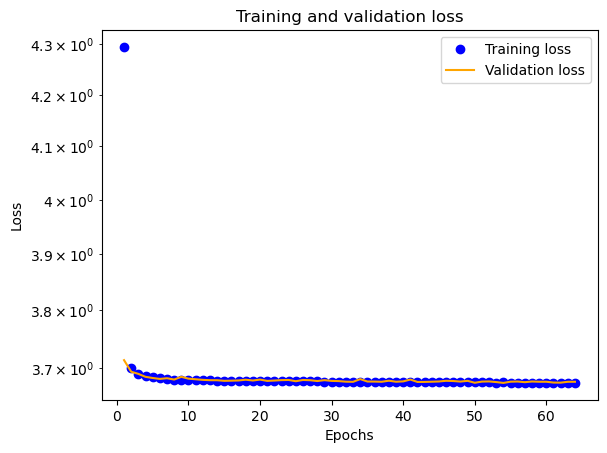

In [8]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [9]:
model.save('models_1Dx/gauss32bit.keras')

In [10]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['xtrue'] = y_test
df.to_csv("test_1DxGauss32bit.csv",header=False,index=False)

In [11]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

-0.3513558766128309 11.715703033302637


In [12]:
uncertainty= p_test[:,1]
print(np.mean(uncertainty),np.std(uncertainty))

9.953117 4.7246847


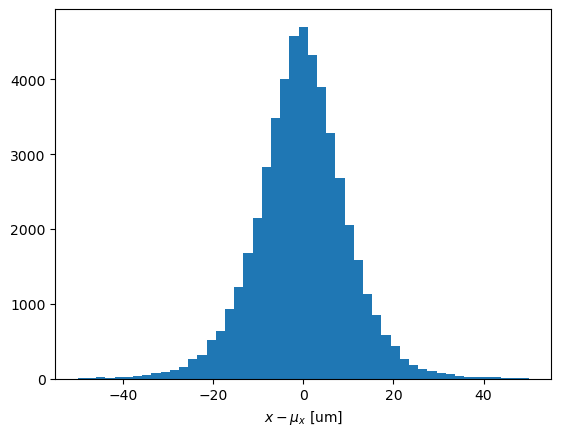

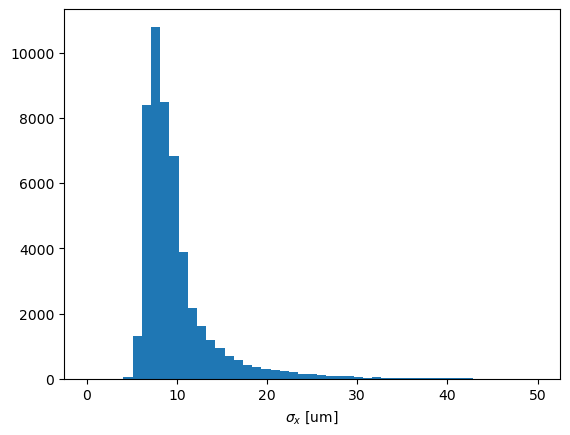

In [13]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,50,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

In [14]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

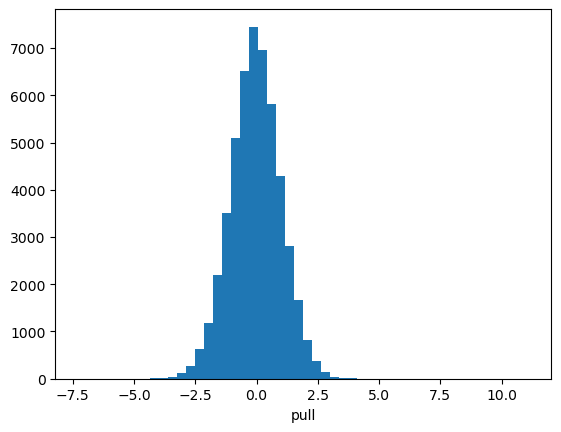

In [15]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [16]:
print(np.mean(pulls),np.std(pulls))

-0.03562598215990116 1.0284610999036272


In [17]:
df_1d32 = pd.read_csv('test_1DxGauss32bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d32.head()

,mu,sigma,xtrue
0,34.354320,6.372603,35.970951
1,-9.736258,7.895556,0.770363
2,-37.632500,7.234630,-37.471662
3,-8.152457,10.563955,-10.147963
4,-60.896202,9.132928,-73.204875


In [18]:
df_1d6 = pd.read_csv('test_1DxGauss6bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d6.head()

,mu,sigma,xtrue
0,25.473694,18.191864,35.970951
1,-10.729095,12.573914,0.770363
2,-27.049011,18.881165,-37.471662
3,-9.286011,11.625275,-10.147963
4,-31.650390,24.006256,-73.204875


In [19]:
df_1d5 = pd.read_csv('test_1DxGauss5bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d5.head()

,mu,sigma,xtrue
0,25.106567,20.301758,35.970951
1,-12.028198,13.900208,0.770363
2,-27.768066,18.706543,-37.471662
3,-9.125977,11.871643,-10.147963
4,-32.064026,23.135010,-73.204875


In [20]:
df_1d = pd.read_csv('test_1DxGauss.csv',header=None,names=['mu','sigma','xtrue'])
df_1d.head()

,mu,sigma,xtrue
0,28.304533,4.178141,35.970951
1,1.501582,4.159173,0.770363
2,-36.650660,3.155224,-37.471662
3,-15.209907,4.208601,-10.147963
4,-68.419350,3.046638,-73.204875


Text(0.5, 0, '$x-\\mu_x$ [um]')

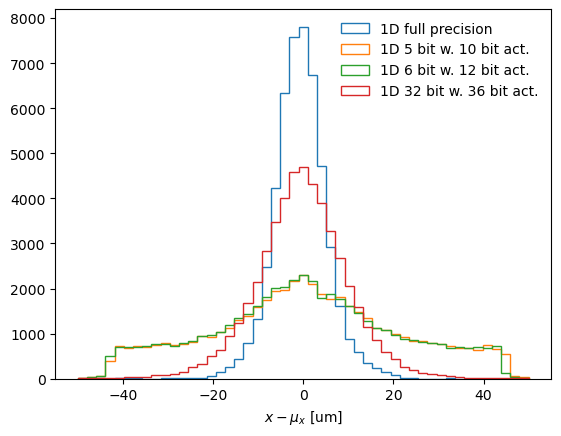

In [21]:
plt.hist(df_1d['xtrue'] - df_1d['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'1D full precision');
plt.hist(df_1d5['xtrue'] - df_1d5['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'1D 5 bit w. 10 bit act.');
plt.hist(df_1d6['xtrue'] - df_1d6['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'1D 6 bit w. 12 bit act.');
plt.hist(df_1d32['xtrue'] - df_1d32['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'1D 32 bit w. 36 bit act.');

plt.legend(frameon=False)
plt.xlabel(r'$x-\mu_x$ [um]')

Text(0.5, 0, '$\\sigma_x$ [um]')

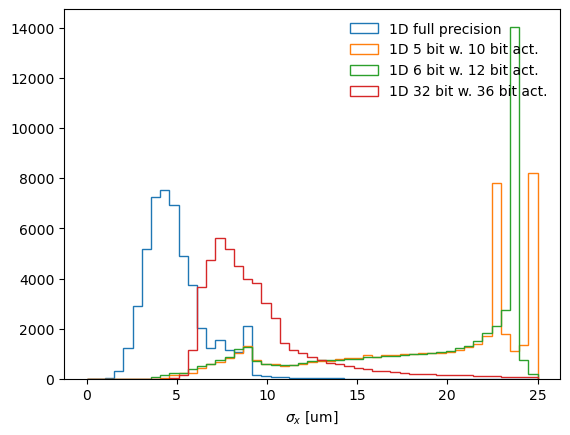

In [22]:
plt.hist(df_1d['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D full precision');
plt.hist(df_1d5['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D 5 bit w. 10 bit act.');
plt.hist(df_1d6['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D 6 bit w. 12 bit act.');
plt.hist(df_1d32['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D 32 bit w. 36 bit act.');
plt.legend(frameon=False)
plt.xlabel(r'$\sigma_x$ [um]')